In [1]:
!git clone https://github.com/shravankgl/DeepLearning-CNN.git

Cloning into 'DeepLearning-CNN'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 33 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [1]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-zggwlw2o
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-zggwlw2o
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98521 sha256=45331775bf24fb278f395afac9fd64db77dbde7d71d6f318c0807d2ea66e8fbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-322iw_hz/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
import sys, os

my_path = '/content/DeepLearning-CNN'
sys.path.append(my_path)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.quicknet import Quicknet
from main import *
from utils import *

Files already downloaded and verified
Files already downloaded and verified


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
model = QuickNet().to(device)

In [13]:
print(model)

QuickNet(
  (prep_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): LayerBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rl): ReLU()
    (resblock): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
  )
  (layer2): Sequential(
  

In [12]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
pip install torch-lr-finder

In [ ]:
from torch_lr_finder import LRFinder

def find_lr(model,train_loader, test_loader, start_lr, end_lr):
                
        lr_epochs = 25
        num_iterations = len(test_loader) * lr_epochs

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.90, weight_decay=0.005)
        lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
        lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=end_lr, num_iter=num_iterations, step_mode="linear",diverge_th=50)
        
        lrmax = lr_finder.plot(suggest_lr=True,skip_start=0, skip_end=0)

        lr_finder.reset()
        return lrmax[1]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.67E-02


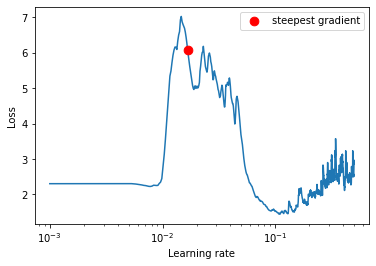

In [ ]:
start_lr = 1e-3
end_lr = 0.5
lrmax= find_lr(model,trainloader, testloader, min_lr, end_lr)





In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR,ReduceLROnPlateau
epochs = 24
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.9, weight_decay=0.005)
#optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=lrmax,
                                  epochs=epochs, steps_per_epoch=len(trainloader),
                                  pct_start=5/epochs,div_factor=8)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]


for epoch in range(24):
    print(f"Epoch {epoch}")
   
    train_loss,train_acc = train(model, device, trainloader, optimizer, epoch)

    test_loss,test_acc = test(model, device, testloader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0


loss=0.9820512533187866 batch_id=390: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]


Train set: Average loss: 0.0114, Accuracy: 24207/50000 (48.41%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.1864, Accuracy: 6323/10000 (63.23%)

Epoch 1


loss=1.0140113830566406 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]


Train set: Average loss: 0.0079, Accuracy: 32602/50000 (65.20%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.9395, Accuracy: 7279/10000 (72.79%)

Epoch 2


loss=0.6586244702339172 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]


Train set: Average loss: 0.0064, Accuracy: 35880/50000 (71.76%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7286, Accuracy: 7458/10000 (74.58%)

Epoch 3


loss=0.7917295694351196 batch_id=390: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Train set: Average loss: 0.0056, Accuracy: 37695/50000 (75.39%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.5686, Accuracy: 7522/10000 (75.22%)

Epoch 4


loss=0.4791623651981354 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Train set: Average loss: 0.0046, Accuracy: 39675/50000 (79.35%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9430, Accuracy: 7962/10000 (79.62%)

Epoch 5


loss=0.5481140613555908 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]


Train set: Average loss: 0.0041, Accuracy: 40982/50000 (81.96%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9198, Accuracy: 7423/10000 (74.23%)

Epoch 6


loss=0.48495930433273315 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]


Train set: Average loss: 0.0038, Accuracy: 41646/50000 (83.29%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9548, Accuracy: 8442/10000 (84.42%)

Epoch 7


loss=0.370624840259552 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Train set: Average loss: 0.0036, Accuracy: 42222/50000 (84.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0214, Accuracy: 8368/10000 (83.68%)

Epoch 8


loss=0.3393266797065735 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Train set: Average loss: 0.0033, Accuracy: 42842/50000 (85.68%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0122, Accuracy: 8435/10000 (84.35%)

Epoch 9


loss=0.4991990923881531 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Train set: Average loss: 0.0032, Accuracy: 43039/50000 (86.08%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9029, Accuracy: 8338/10000 (83.38%)

Epoch 10


loss=0.33473241329193115 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]


Train set: Average loss: 0.0031, Accuracy: 43252/50000 (86.50%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0053, Accuracy: 8466/10000 (84.66%)

Epoch 11


loss=0.4427691400051117 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]


Train set: Average loss: 0.0030, Accuracy: 43540/50000 (87.08%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1908, Accuracy: 8571/10000 (85.71%)

Epoch 12


loss=0.3146713376045227 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]


Train set: Average loss: 0.0028, Accuracy: 43818/50000 (87.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4634, Accuracy: 8598/10000 (85.98%)

Epoch 13


loss=0.4381236135959625 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]


Train set: Average loss: 0.0028, Accuracy: 43999/50000 (88.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5919, Accuracy: 8753/10000 (87.53%)

Epoch 14


loss=0.3526217043399811 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Train set: Average loss: 0.0026, Accuracy: 44456/50000 (88.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3527, Accuracy: 8689/10000 (86.89%)

Epoch 15


loss=0.41579899191856384 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]


Train set: Average loss: 0.0024, Accuracy: 44794/50000 (89.59%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7327, Accuracy: 8769/10000 (87.69%)

Epoch 16


loss=0.24312397837638855 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Train set: Average loss: 0.0022, Accuracy: 45237/50000 (90.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2271, Accuracy: 8868/10000 (88.68%)

Epoch 17


loss=0.2687041461467743 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]


Train set: Average loss: 0.0020, Accuracy: 45812/50000 (91.62%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3293, Accuracy: 8944/10000 (89.44%)

Epoch 18


loss=0.3915124237537384 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Train set: Average loss: 0.0017, Accuracy: 46502/50000 (93.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5539, Accuracy: 8963/10000 (89.63%)

Epoch 19


loss=0.20456281304359436 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Train set: Average loss: 0.0013, Accuracy: 47321/50000 (94.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0152, Accuracy: 9076/10000 (90.76%)

Epoch 20


loss=0.11199953407049179 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]


Train set: Average loss: 0.0010, Accuracy: 48078/50000 (96.16%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0460, Accuracy: 9174/10000 (91.74%)

Epoch 21


loss=0.10104706138372421 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]


Train set: Average loss: 0.0008, Accuracy: 48611/50000 (97.22%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2683, Accuracy: 9220/10000 (92.20%)

Epoch 22


loss=0.11533256620168686 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]


Train set: Average loss: 0.0006, Accuracy: 48955/50000 (97.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2064, Accuracy: 9271/10000 (92.71%)

Epoch 23


loss=0.06154952198266983 batch_id=390: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Train set: Average loss: 0.0005, Accuracy: 49120/50000 (98.24%)




Test set: Average loss: -9.2541, Accuracy: 9264/10000 (92.92%)



In [ ]:
from pylab import *

def getWrongPredictions(model, device, val_loader):
    wrong_idx = []
    wrong_samples = []
    wrong_preds = []
    actual_values = []

    for data,target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
        wrong_samples.append(data[wrong_idx])
        wrong_preds.append(pred[wrong_idx])
        actual_values.append(target.view_as(pred)[wrong_idx])
    return list(zip(torch.cat(wrong_samples),torch.cat(wrong_preds),torch.cat(actual_values)))

def plotWrongPredictions(wrong_predictions):
    fig = plt.figure(figsize=(10,10))
    mean,std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    for i, (sample, wrong_pred, actual_value) in enumerate(wrong_predictions[:20]):
        sample, wrong_pred, actual_value = sample.cpu().numpy(), wrong_pred.cpu(), actual_value.cpu()
        # Undo normalization
        for j in range(sample.shape[0]):
            sample[j] = (sample[j]*std[j])+mean[j]
        sample = np.transpose(sample, (1, 2, 0))
        ax = fig.add_subplot(4, 5, i+1)
        ax.axis('off')
        ax.set_title(f'actual {classes[actual_value.item()]}\npredicted {classes[wrong_pred.item()]}',fontsize=15)
        ax.imshow(sample)
    plt.show()

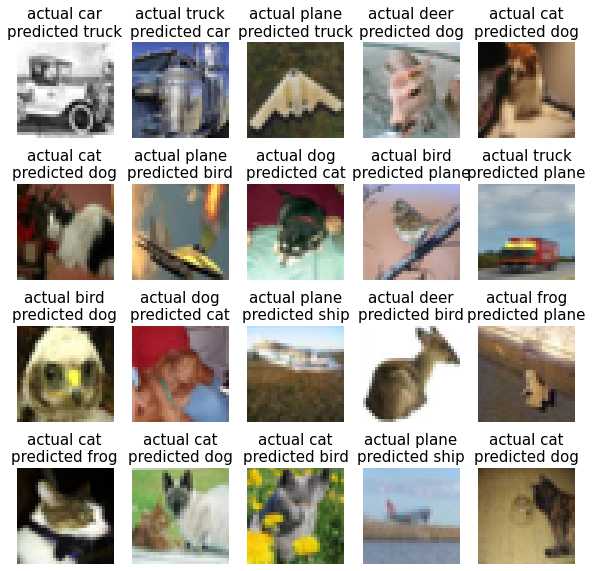

In [ ]:
wp = getWrongPredictions(model, device, testloader)
plotWrongPredictions(getWrongPredictions(model, device, testloader))

In [ ]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 15.8MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp37-none-any.whl size=5269 sha256=359d4956dd0888ba289f6ef358fea052cb0dbfd2b4add2f2ccc909e44e78770a
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [ ]:
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer1'),
    dict(model_type='resnet', arch=model, layer_name='layer2'),
    dict(model_type='resnet', arch=model, layer_name='layer3'),
    #dict(model_type='resnet', arch=model, layer_name='layer4'),
]

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [ ]:
wp = getWrongPredictions(model, device, testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
def imshow(img,c = "" ):    
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

In [ ]:
from torchvision import transforms
from torchvision.utils import make_grid, save_image
inv_norm = transforms.Normalize((-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010), (1/0.2023, 1/0.1994, 1/0.2010))

def plotGradCam(wrong_predictions):
    for i, (sample, wrong_pred, actual_value) in enumerate(wrong_predictions[:20]):
        torch_img = inv_norm(sample)
        normed_torch_img = sample[None]
        images = []
        for gradcam, gradcam_pp in cams:
            mask, _ = gradcam(normed_torch_img)
            heatmap, result = visualize_cam(mask, torch_img)

            mask_pp, _ = gradcam_pp(normed_torch_img)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
            
            images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
            
        grid_image = make_grid(images, nrow=5)
        imshow(grid_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


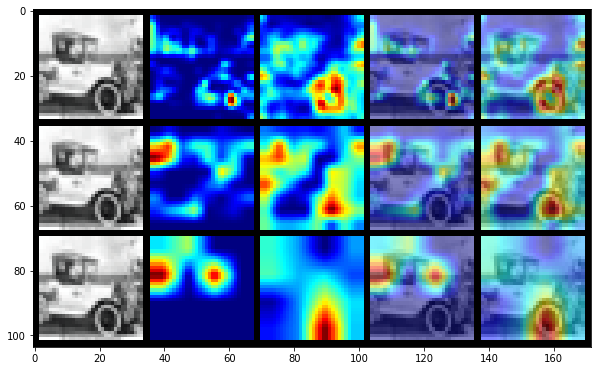

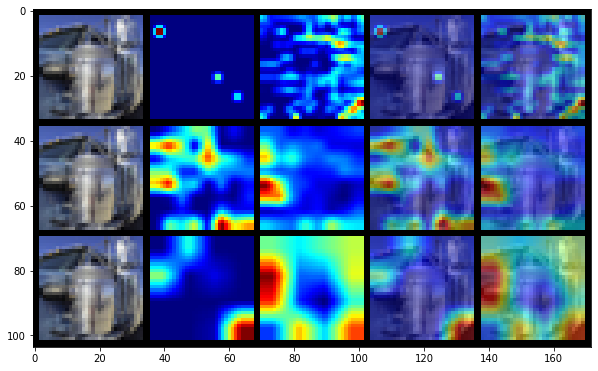

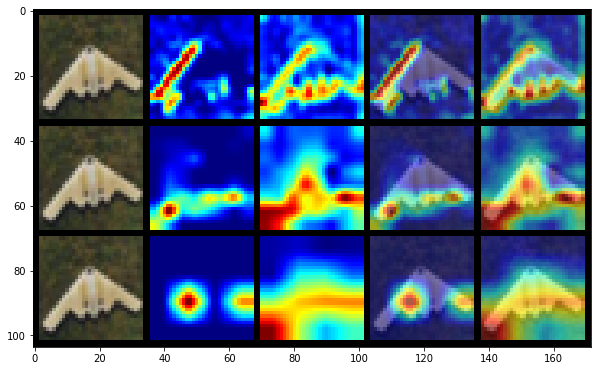

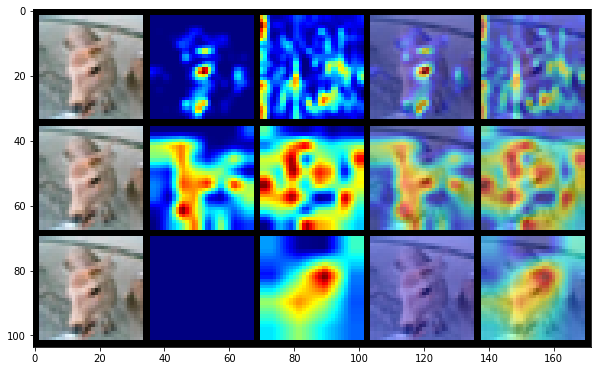

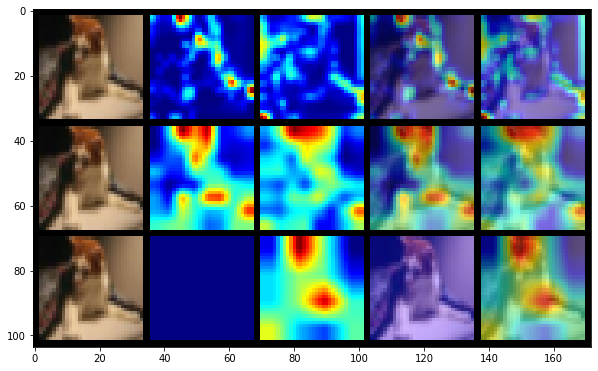

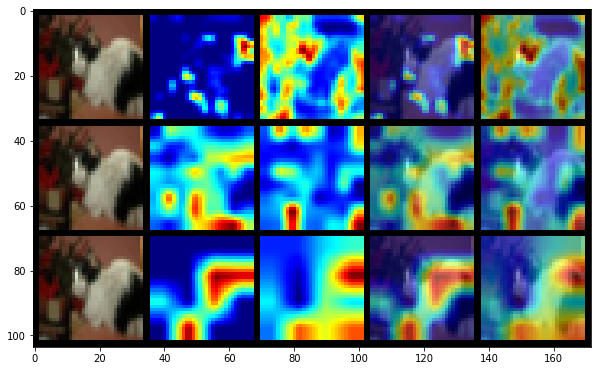

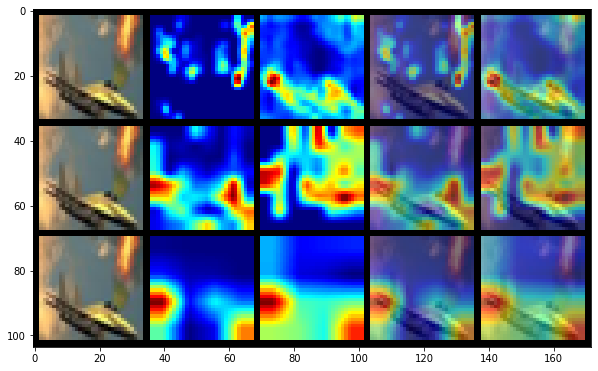

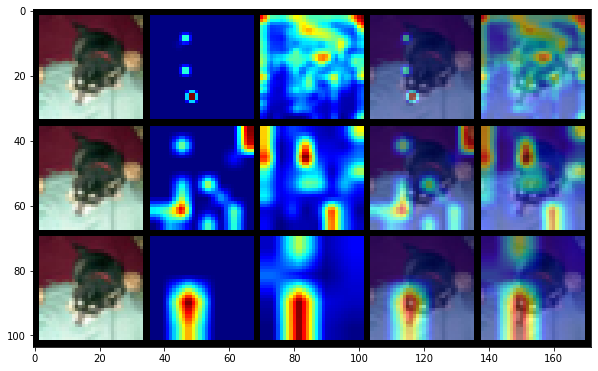

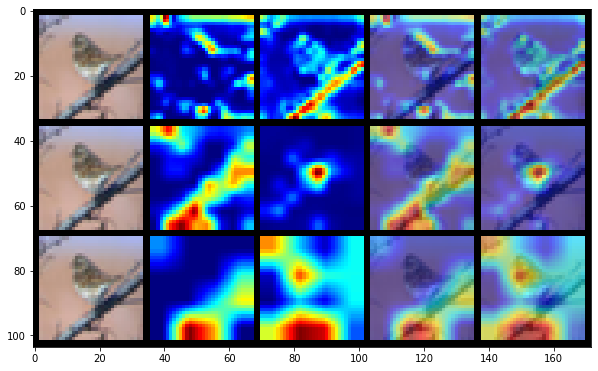

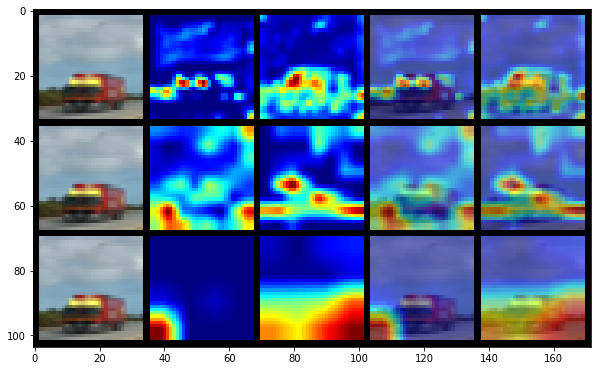

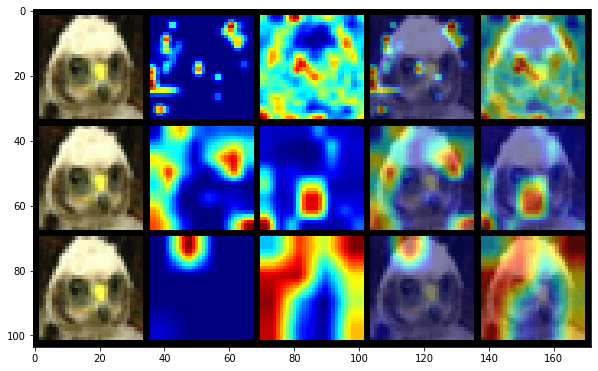

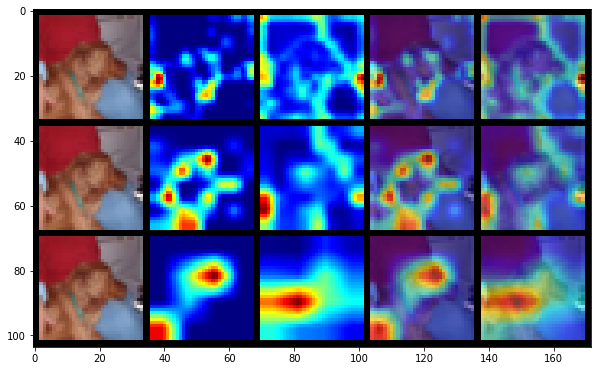

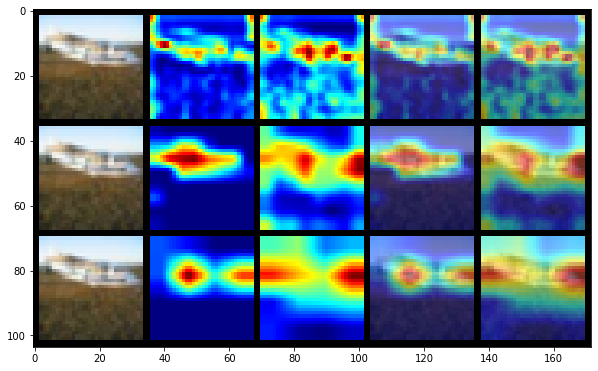

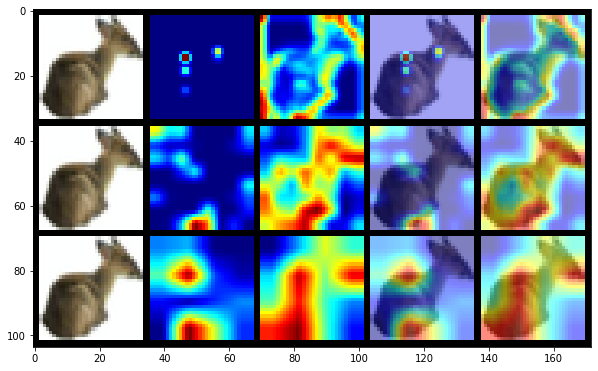

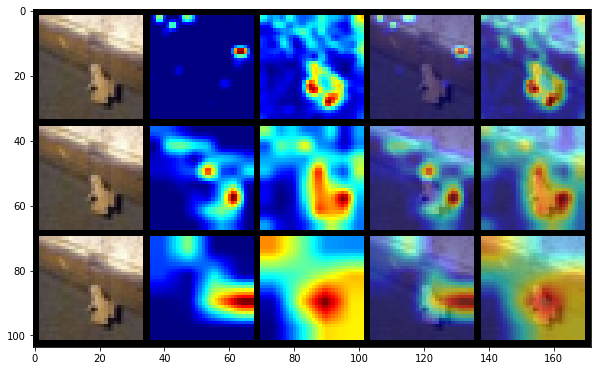

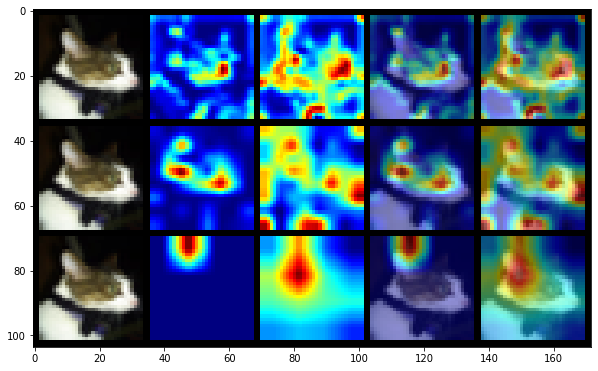

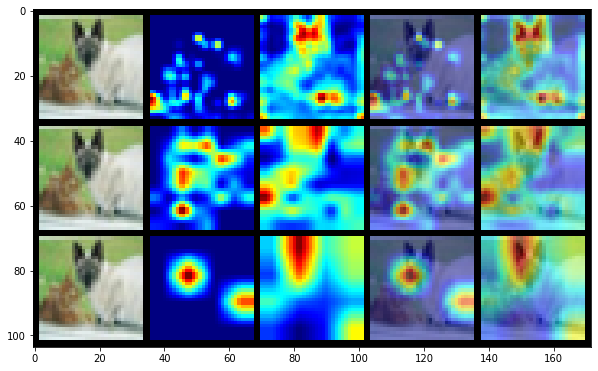

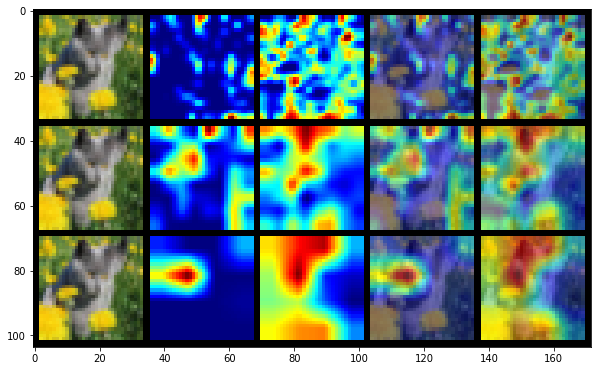

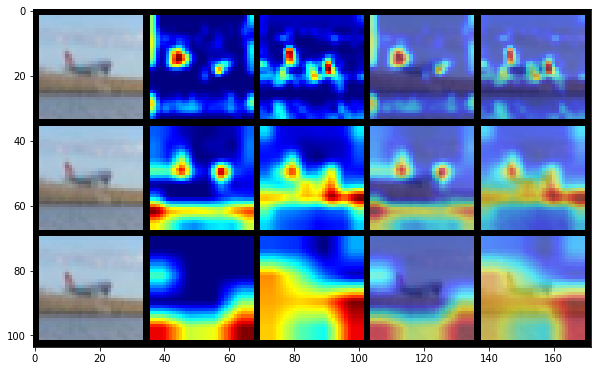

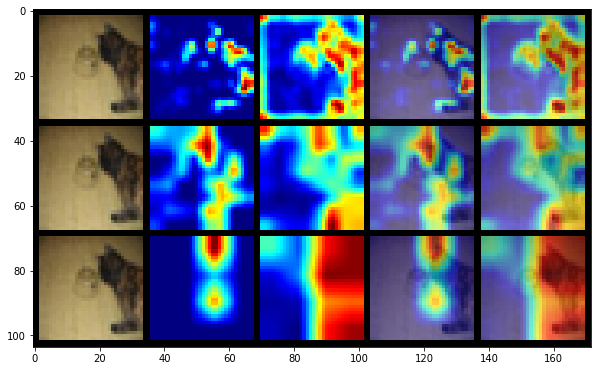

In [ ]:
plotGradCam(wp[:20])